In [5]:
# Import required libraries

import torch  # PyTorch for deep learning
import keras  # Keras for additional ML functionality
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical computing
from tqdm import tqdm  # Progress bar
from matplotlib import pyplot as plt  # Plotting
from torch.utils.data import Dataset, DataLoader  # Data handling

In [6]:
# Custom Dataset class for handling 3D grid data

class GridsDataset(Dataset):
    def __init__(self, grids_list, labels):
        self.grids_list = grids_list
        self.labels = labels

    def __len__(self):
        return len(self.grids_list)

    def __getitem__(self, idx):
        grid = self.grids_list[idx]
        label = self.labels[idx]
        grid_tensor = torch.from_numpy(grid)
        return grid_tensor, label

In [7]:
# Load and prepare the dataset

capstone_dataset = np.load('AIM_240_Dataset.npz')

flat = capstone_dataset['objects']
labels = ['Bag'] * 50 + ['Bowl'] * 50 + ['Earphone'] * 50 + ['Guitar'] * 50 + ['Knife'] * 50 + ['Laptop'] * 50 + ['Pistol'] * 50 + ['Rocket'] * 50 + ['Skateboard'] * 50


In [8]:
# Create dataset and dataloader instances
dataset = GridsDataset(flat, labels)
dataloader = DataLoader(dataset, shuffle=True)


In [9]:
# Split dataset into training and testing sets (80-20 split)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders with batch size of 4
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # No need to shuffle test data

# Prepare training and testing data
trainX = []
trainY = []
testX = []
testY = []

# Extract data from dataloaders
for batch_grids, batch_labels in train_dataloader:
    trainX.extend(batch_grids)
    trainY.extend(batch_labels)

for batch_grids, batch_labels in test_dataloader:
    testX.extend(batch_grids)
    testY.extend(batch_labels)

# Convert to numpy arrays for easier manipulation
trainX = torch.stack(trainX).numpy()
trainY = np.array(trainY)
testX = torch.stack(testX).numpy()
testY = np.array(testY)

In [10]:
def get_minibatch(batch_size):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    return torch.tensor(trainX[indices], dtype=torch.float).reshape(batch_size, -1)


def sample_noise(size, dim=100):
    out = torch.empty(size, dim)
    mean = torch.zeros(size, dim)
    std = torch.ones(dim)
    torch.normal(mean, std, out=out)
    return out


class Generator(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, output_dim=16 * 16 * 16):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),  #
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh(),
        )

    def forward(self, noise):
        return self.network(noise)

class Discriminator(nn.Module):
    def __init__(self, input_dim=16 * 16 * 16, hidden_dim=128, output_dim=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

def train(generator, discriminator, gen_optimizer, disc_optimizer, nb_epochs, k=1, batch_size=32):
    training_loss = {'generative': [], 'discriminator': []}
    for epoch in tqdm(range(nb_epochs)):
        # Train the discriminator
        for _ in range(k):
            z = sample_noise(batch_size).to(device)
            x = get_minibatch(batch_size).to(device)
            # Update the discriminator
            disc_optimizer.zero_grad()
            # Reshape target tensors to match discriminator output shape
            f_loss = torch.nn.BCELoss()(discriminator(generator(z)), torch.zeros(batch_size, 1, device=device))
            r_loss = torch.nn.BCELoss()(discriminator(x), torch.ones(batch_size, 1, device=device))
            loss = (r_loss + f_loss) / 2
            loss.backward()
            disc_optimizer.step()
            training_loss['discriminator'].append(loss.item())

        # Train the generator
        z = sample_noise(batch_size).to(device)
        # Update the generator
        gen_optimizer.zero_grad()
        # Reshape target tensors to match discriminator output shape
        loss = torch.nn.BCELoss()(discriminator(generator(z)), torch.ones(batch_size, 1, device=device))
        loss.backward()
        gen_optimizer.step()
        training_loss['generative'].append(loss.item())

    return training_loss


if __name__ == "__main__":
        device = 'cuda:0'

        discriminator = Discriminator().to(device)
        generator = Generator().to(device)

        optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        loss = train(generator, discriminator, optimizer_g, optimizer_d, 800, batch_size=32)

100%|██████████| 800/800 [00:07<00:00, 105.74it/s]


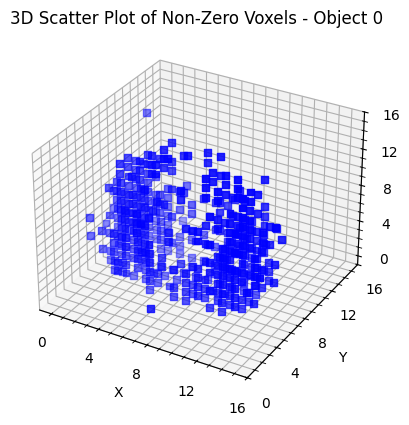

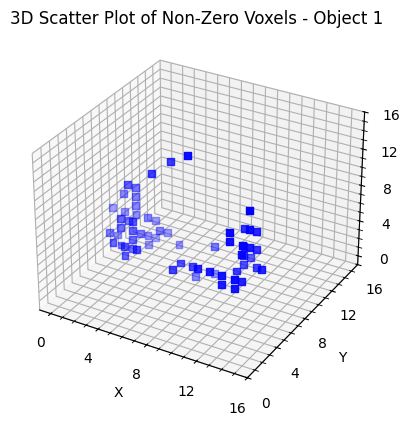

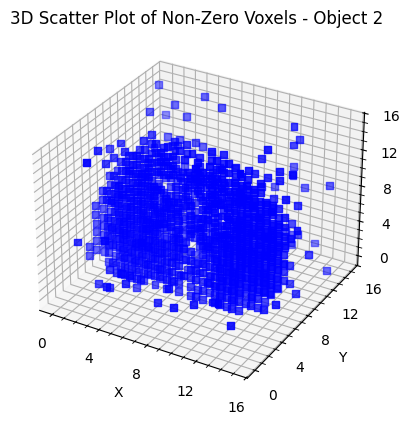

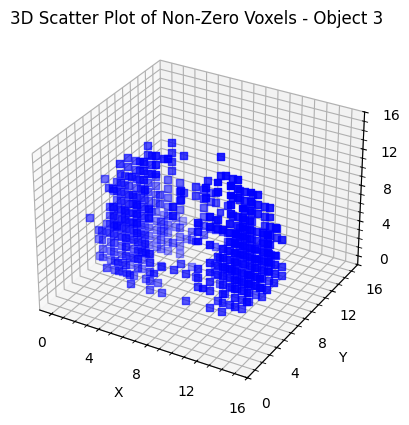

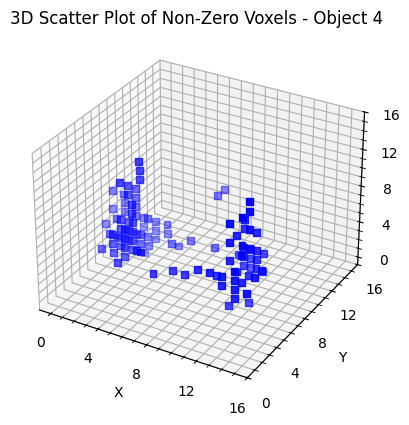

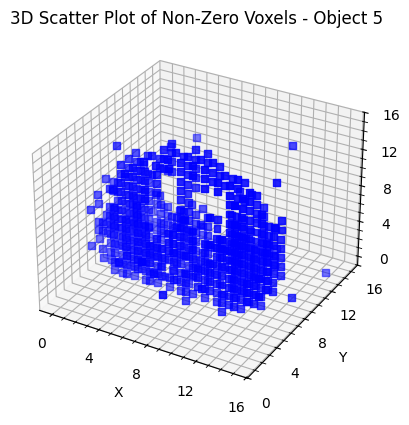

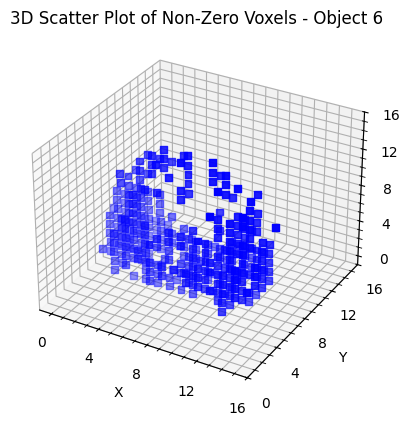

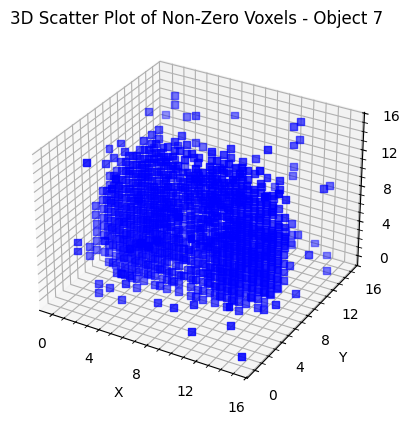

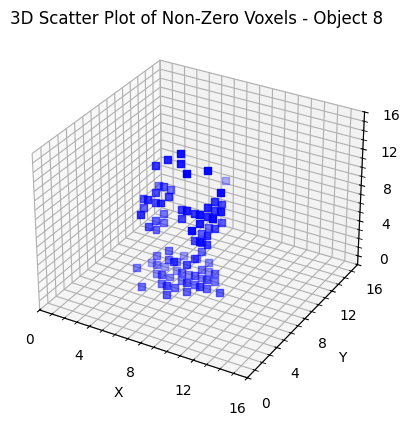

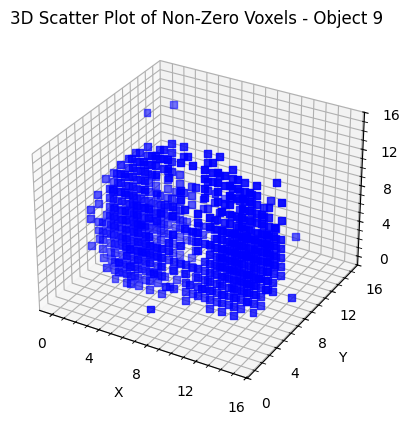

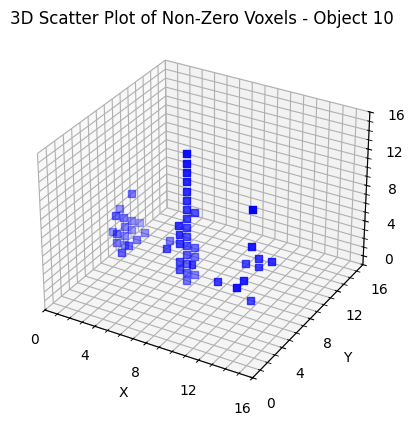

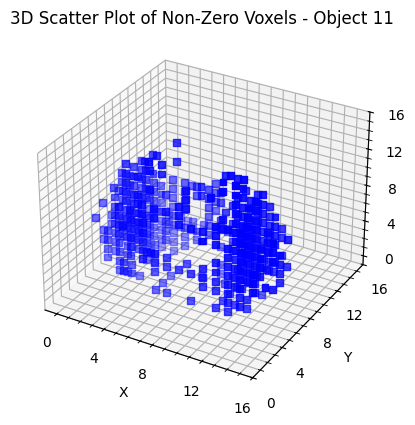

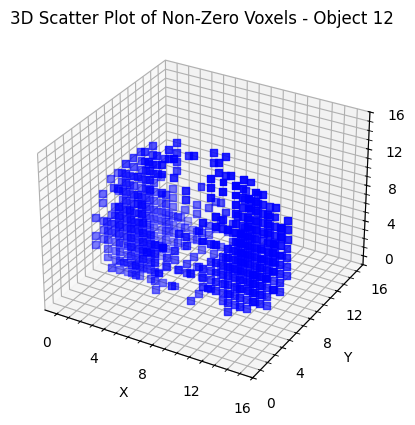

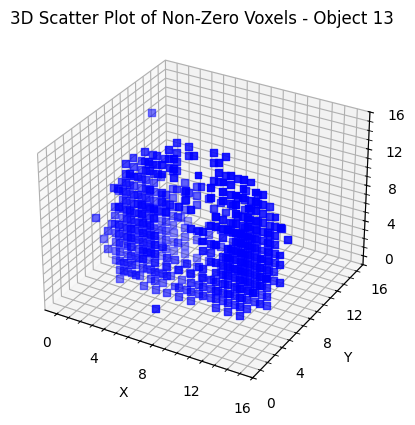

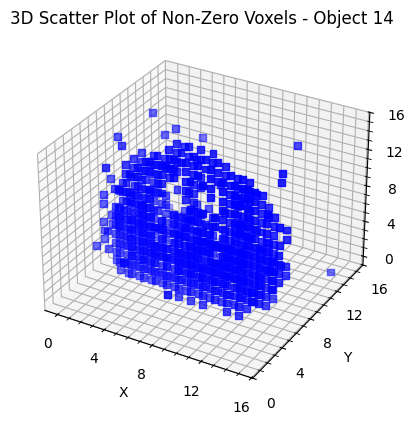

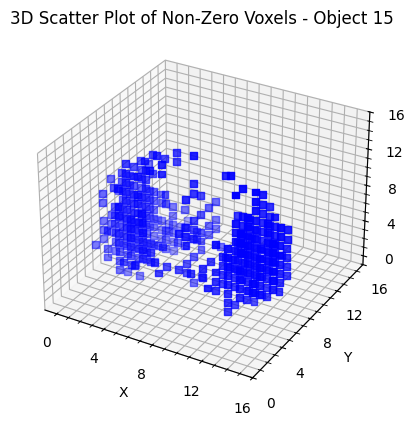

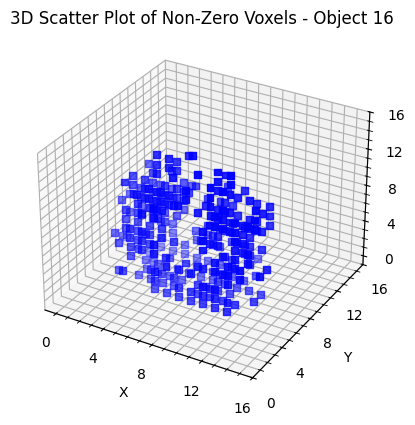

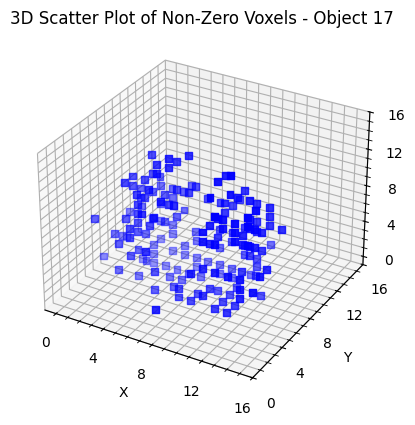

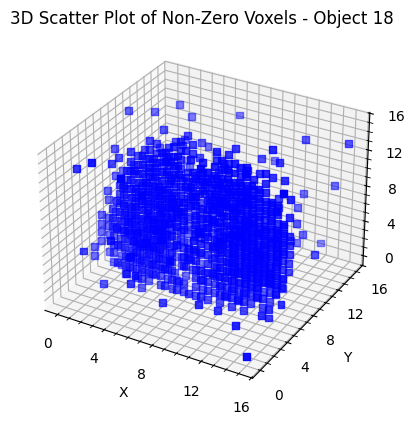

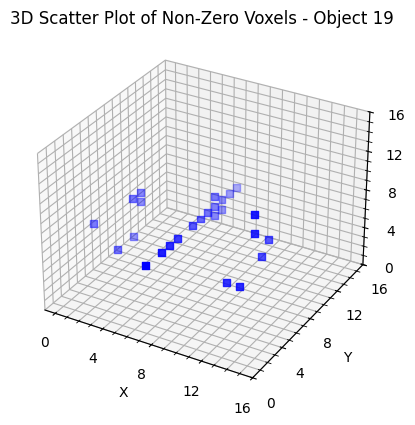

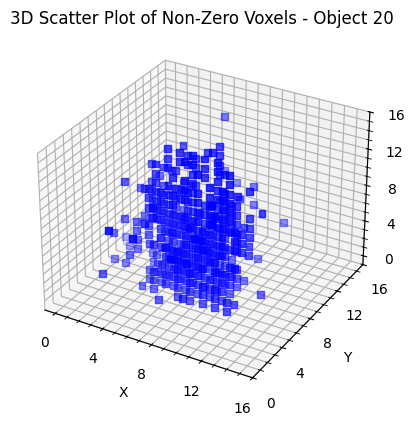

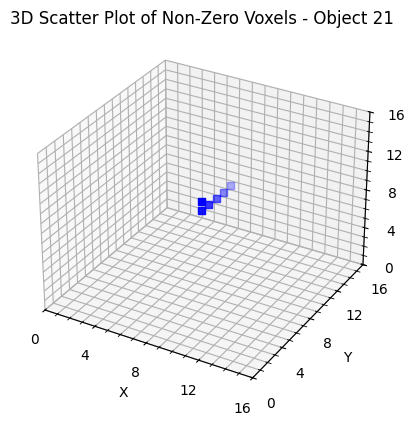

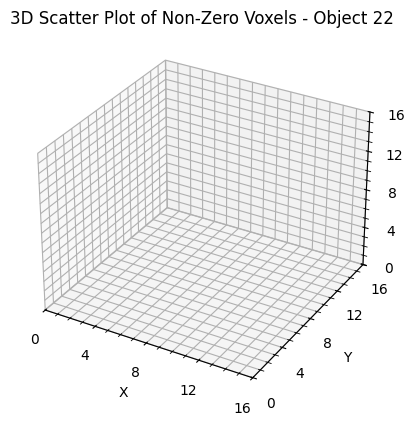

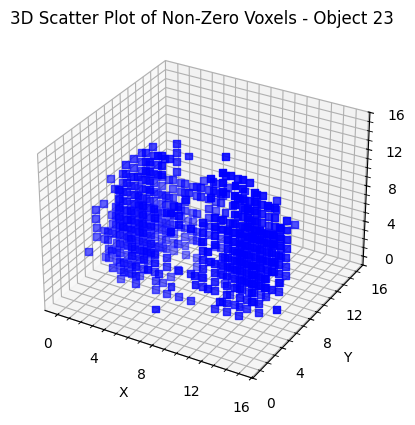

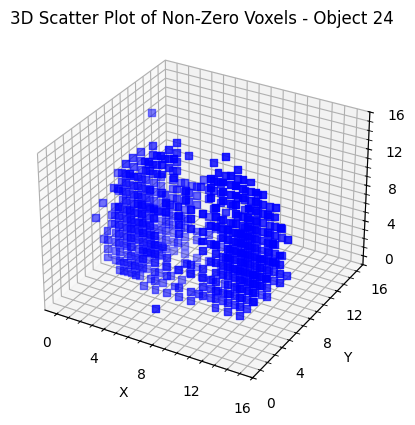

In [11]:
# Generate and visualize 3D objects

NB_IMAGES = 25
z = sample_noise(NB_IMAGES).to(device)
x = generator(z)
output = x.cpu().detach().numpy()
output = output.reshape(NB_IMAGES, 16, 16, 16)
threshold = .22

# Visualize generated objects
for j in range(NB_IMAGES):  # Iterate through all generated objects
  just = output[j]  # Get the current object
  just = just.reshape(16, 16, 16, 1)

  # Find voxels above threshold
  x, y, z = np.where(just[..., 0] > threshold)

  # Create 3D scatter plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x, z, y, s=25, c='b', marker='s')

  # Set up grid
  major_ticks = np.arange(0, 17, 4)
  minor_ticks = np.arange(0, 17, 1)
  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(major_ticks)
  ax.set_yticks(minor_ticks, minor=True)
  ax.set_zticks(major_ticks)
  ax.set_zticks(minor_ticks, minor=True)
  # Set labels and title
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title(f'3D Scatter Plot of Non-Zero Voxels - Object {j}')
  plt.show()

